In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from Chandra.Time import DateTime
from Ska.Matplotlib import plot_cxctime
from Ska.engarchive import fetch as fetch
from Ska.Numpy import interpolate
import tables

In [2]:
# GOES data archived through Replan Central
h5_file = "/proj/sot/ska/data/arc3/hrc_shield.h5"

In [3]:
with tables.open_file(h5_file, mode='r',
                      filters=tables.Filters(complevel=5, complib='zlib')) as h5:
    table = h5.root.data

In [4]:
h5 = tables.open_file(h5_file, mode='r')
table = h5.root.data
sat = table.col('satellite')
secs = table.col('time')
p1 = table.col('p1')
p2a = table.col('p2a')
p2b = table.col('p2b')
p3 = table.col('p3')
p4 = table.col('p4')
p5 = table.col('p5')
p6 = table.col('p6')
p7 = table.col('p7')
p8a = table.col('p8a')
p8b = table.col('p8b')
p8c = table.col('p8c')
p9 = table.col('p9')
hrc_shield = table.col('hrc_shield')
h5.close()

In [5]:
START_DATE = '2020:329:00:00:00'

In [6]:
def plot_goes_channel(chan, label, ymax):
    fig = plt.figure(1, figsize=(12, 4))

    good = (hrc_shield > 0.1) & (sat == 16) & (secs > DateTime(START_DATE).secs)
    x = secs[good]
    y = chan[good]
    plot_cxctime(x, y, color='k', label=f'{label}')

    N = 60
    y_mean = np.convolve(y, np.ones((N,))/N, mode='valid')
    plot_cxctime(x[N - 1:], y_mean, color='cyan', label='Running mean')

    plt.grid()
    plt.ylim(-0.0025, ymax)
    plt.ylabel('p / cm^2-s-sr-MeV')
    plt.legend()
    plt.tight_layout()

In [7]:
def plot_hrc_shield(times, vals, color='C0', marker=None, linestyle='solid', scale='log', label=''):
    secs = times
    hrc_shield = vals
    bad = hrc_shield < 256
    hrc_shield = hrc_shield[~bad]
    secs = secs[~bad]

    plt.figure(1, figsize=(6, 4))
    ticks, fig, ax = plot_cxctime(secs, hrc_shield, label=label,
                                  color=color, marker=marker, linestyle=linestyle)
    ax.set_yscale(scale)
    plt.grid()
    plt.ylabel('Cts / sample')
    plt.tight_layout()

In [8]:
dat = fetch.Msid('2shldbrt', START_DATE) # sample every ~8sec

In [9]:
good = (hrc_shield > 0.1) & (sat == 16) & (secs > DateTime(START_DATE).secs)
times = secs[good]

In [10]:
# Interpolate 2SHLDBRT data on the time axis of GOES data
vals = interpolate(dat.vals, dat.times, times, method='nearest')

In [11]:
from sherpa.astro import ui

In [12]:
# Fitting

pars0 = [5000, 2e6, 2e5]

def hrc_shield_proxy(pars, ch0, ch1, ch2):
    c0, c1, c2 = pars
    return c0 * ch0 + c1 * ch1 + c2 * ch2


def hrc_shield_proxy_model(ch0, ch1, ch2):
    
    def sherpa_func(pars, x=None):
        return hrc_shield_proxy(pars, ch0, ch1, ch2)
    
    return sherpa_func


def fit_hrc_proxy(times, vals):
    data_id = 1
    nn = 3
    comp_names = [f'c{i}' for i in range(nn)]
    ui.set_method('simplex')
    ui.set_stat('cash')
    
    good = (hrc_shield > 0.1) & (sat == 16) & (secs > DateTime(START_DATE).secs)
    ch0 = p6[good]
    ch1 = p7[good]
    ch2 = p9[good]
    ui.load_user_model(hrc_shield_proxy_model(ch0, ch1, ch2), 'model')
        
    ui.add_user_pars('model', comp_names)
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id, np.array(times), np.array(vals))

    # Initial fit values
    fmod = ui.get_model_component('model')
    for i in range(nn):
        comp_name = f'c{i}'
        setattr(fmod, comp_name, pars0[i])
        comp = getattr(fmod, comp_name)
        comp.max = 1e7
        comp.min = 1
        
    ui.fit(data_id)
    #conf = ui.get_confidence_results()
    return ui.get_fit_results()

In [13]:
res1 = fit_hrc_proxy(times, vals)

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = -4.05985e+08
Final fit statistic   = -4.06218e+08 at function evaluation 406
Data points           = 6393
Degrees of freedom    = 6390
Change in statistic   = 232531
   model.c0       1           
   model.c1       2.2034e+06  
   model.c2       201121      


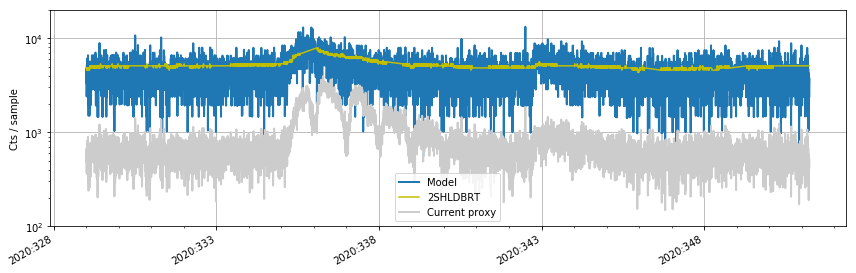

In [14]:
plt.figure(figsize=(12, 4))
y_model = hrc_shield_proxy(res1.parvals, p6[good], p7[good], p9[good])
plot_cxctime(times, y_model, '-', lw=2, label='Model')
plot_hrc_shield(times, vals, color='y', label='2SHLDBRT')
plot_cxctime(secs[good], hrc_shield[good] * 256, '-', color='#cccccc', lw=2, label='Current proxy')

plt.legend()
plt.ylim(100, 20000);

__Figure:__ First attempt to recalibrate the HRC shield proxy by levaraging a recent mild Solar activity (C-class flare and Earth directed CME). Blue region shows a new 'model': a combination of GOES-16 rates in channels P6, P7, P9 with coefficients c0, c1, c2 (see the cell above) fit to the B-side HRC shield rates (2SHLDBRT) between days 2020:328 and 2020:352. 

__Note 1:__ Gray region illustrates the old HRC proxy formula that includes coefficients derived by correlating the previous generation GOES rates and A-side HRC shield rates, applied to GOES-16 P5, P7 and P9 rates. The old description clearly underestimates the HRC shield rate.

__Note 2:__ While this is an encouraging first attempt to recalibrate the HRC shield proxy, we need more flaring data to understand the details. For example, it appears that for this event there is little dependence on the softest and hardest rates (P6 and P9, respectively), and we missed the 'peak' of shield rates due to a radiation zone passage.


## Galery of flare profiles in different energy channels

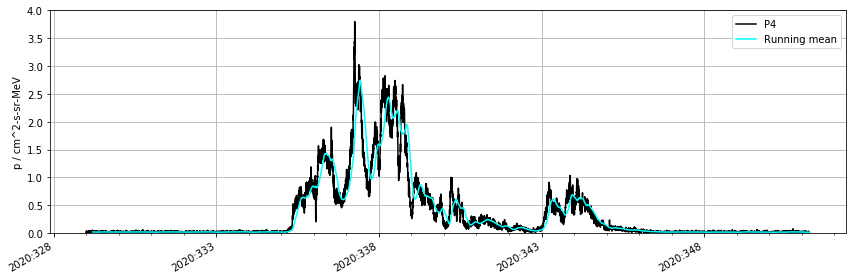

In [15]:
# 5.84-11 MeV
plot_goes_channel(p4, 'P4', 4)

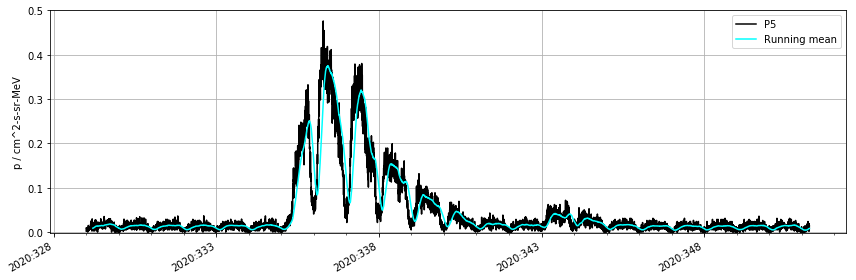

In [16]:
# 11.64-23.27 MeV
plot_goes_channel(p5, 'P5', 0.5)

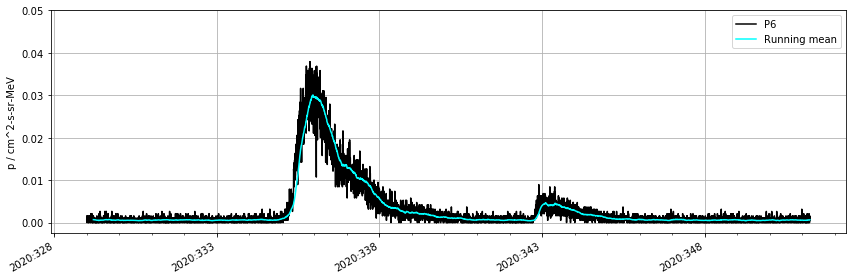

In [17]:
# 25.9-38.1 MeV
plot_goes_channel(p6, 'P6', 0.05)

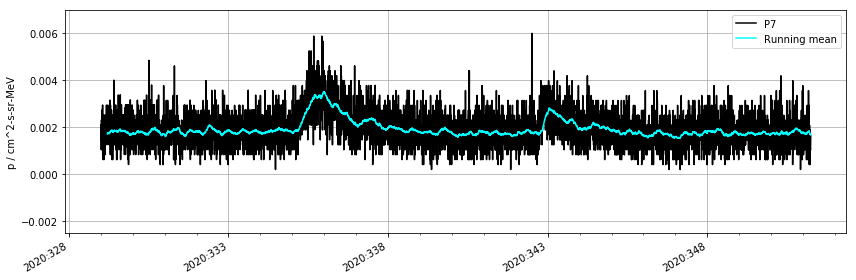

In [18]:
# 40.3-73.4 keV
plot_goes_channel(p7, 'P7', 0.007)

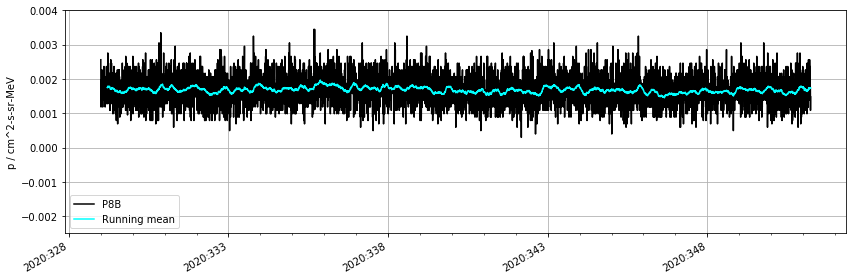

In [19]:
# 99.9-118 MeV
plot_goes_channel(p8b, 'P8B', 0.004)

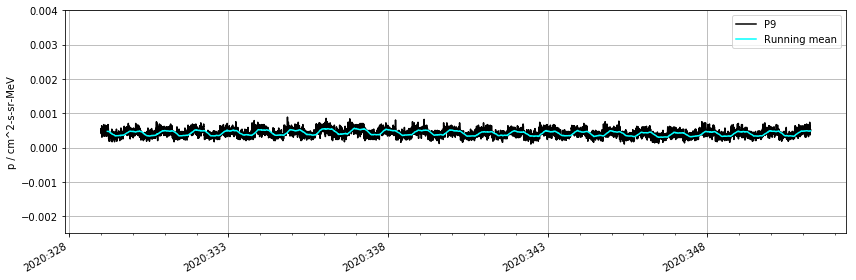

In [20]:
# 160-242 MeV
plot_goes_channel(p9, 'P9', 0.004)